# In this notebook, we will solve the problem of extracting text from a single-page PDF using Optical Character Recognition (OCR) and save the extracted text to an Excel file. Here are the steps we will follow:

1.	Install necessary libraries: We need to install libraries for OCR and PDF processing.
2.	Preprocessing the image: Before applying OCR, the image from the PDF needs to be preprocessed for better text extraction.
3.	OCR (Text extraction): We will use Tesseract OCR to extract the text from the processed image.
4.	Organize data: After extracting the text, we will structure it in a tabular format.
5.	Save results to Excel: Finally, we will save the extracted and organized data to an Excel file.

Prompt to AI:

`*“Please provide a detailed explanation of the processes required to extract characters from a PDF file, specifically from a single page, and save the extracted text into an Excel file. Additionally, explain the image processing methods that should be used for this task, particularly focusing on enhancing the image quality for better OCR results. Provide a step-by-step list of necessary processes to achieve this, and then generate the Python code that can be run on Google Colab to perform this task. Finally, I will compare the extracted data with manually created Excel files to evaluate how well the code performs.”*`

In [ ]:
# @title ## 1. Install Necessary Libraries
# Install Tesseract OCR and PDF utilities
!sudo apt install tesseract-ocr poppler-utils -qq
# Install Python libraries: pytesseract for OCR, pdf2image to convert PDFs to images, OpenCV for image processing, pandas for saving the result to Excel
!pip install pytesseract pdf2image opencv-python-headless pandas -q

tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


# Why do we use these libraries?
	•	Tesseract OCR: It is an open-source OCR engine that is capable of extracting text from images.
	•	pdf2image: This library converts PDF pages into images, making them compatible with OCR.
	•	opencv: OpenCV provides various image processing techniques like noise reduction, thresholding, and converting images to grayscale, which are important for improving OCR accuracy.
	•	pandas: We use this to structure the extracted data and save it in an Excel file.

In [ ]:
# @title ## 2. Import Libraries
import cv2
import pytesseract
import pandas as pd
import numpy as np
from pdf2image import convert_from_path
from google.colab import files
import matplotlib.pyplot as plt

# Why do we import these libraries?
	•	cv2 (OpenCV): For image processing such as converting to grayscale, applying thresholding, and noise reduction.
	•	pytesseract: To extract text from images using OCR.
	•	pandas: To create and save data in a structured format (Excel).
	•	convert_from_path: To convert PDF pages into images.
	•	files: To allow file upload and download within the Colab environment.
	•	matplotlib: For visualizing the original and processed images.

# **We need to define a class that will handle the entire PDF-to-Excel conversion process. This class will take care of:**
	•	Converting the PDF page into an image.
	•	Preprocessing the image to improve OCR accuracy.
	•	Running OCR to extract the text.
	•	Structuring the extracted text into a table.

In [ ]:
# @title ## 3. PDF Processing Class
class PDFToExcelConverter:
    def __init__(self, dpi=400, lang='eng'):
        """
        Problem: Different quality PDFs require flexible processing
        Solution: Use adjustable parameters for dynamic handling
        """
        self.dpi = dpi  # 300-600 DPI is recommended for high-quality OCR
        self.lang = lang  # OCR language (e.g., English)
        self.preprocess_params = {
            'threshold_block': 21,  # Block size for thresholding
            'denoise_strength': 12   # Strength for denoising the image
        }

    def _preprocess_image(self, image):
        """Preprocess the image for better OCR accuracy"""
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Apply adaptive thresholding to highlight the text areas
        thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            self.preprocess_params['threshold_block'],
            8
        )

        # Denoise the image to remove any noise
        denoised = cv2.fastNlMeansDenoising(
            thresh,
            h=self.preprocess_params['denoise_strength']
        )
        return denoised

    def convert(self, pdf_path):
        """Main conversion process: PDF to Excel"""
        # Convert PDF to image
        images = convert_from_path(pdf_path, dpi=self.dpi)
        if not images:
            raise ValueError("Unable to read PDF or it might be corrupted!")

        # Process the first page image
        original = np.array(images[0])
        processed = self._preprocess_image(original)

        # Perform OCR using Tesseract
        config = f'--oem 3 --psm 6 -l {self.lang}'
        data = pytesseract.image_to_data(
            processed,
            config=config,
            output_type=pytesseract.Output.DATAFRAME
        )

        # Clean the data: Remove rows with no text or low confidence
        clean_data = data[(data.conf > 60) & (data.text.notna())]
        structured = clean_data.pivot_table(
            index=['block_num', 'line_num'],
            values='text',
            aggfunc=lambda x: ' '.join(x.str.strip())
        ).reset_index()

        return original, processed, structured

# **Why do we use this class?**
	•	The class modularizes the process of extracting text from a PDF.
	•	It handles the PDF-to-image conversion, image preprocessing, OCR, and structuring the data, making the whole process more manageable and reusable.
	•	We use convert_from_path to convert the PDF to an image, and then preprocess it using thresholding and denoising to optimize the image for OCR.




In [ ]:
# @title ## 4. Image Comparison
def show_comparison(orig, proc):
    """Visualize original vs. processed image"""
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1).imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title("Original PDF Image", fontsize=12)
    plt.axis('off')
    plt.subplot(1,2,2).imshow(proc, cmap='gray')
    plt.title("Processed Image (OCR Optimized)", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# **Why do we use this function?**
	•	This helps us compare how well preprocessing has improved the image, giving us insights into the impact of techniques like thresholding and denoising.
	•	Visualizing this step helps in debugging and optimizing the image processing techniques.


Processing PDF: /content/12_1987-1988-36-40.pdf


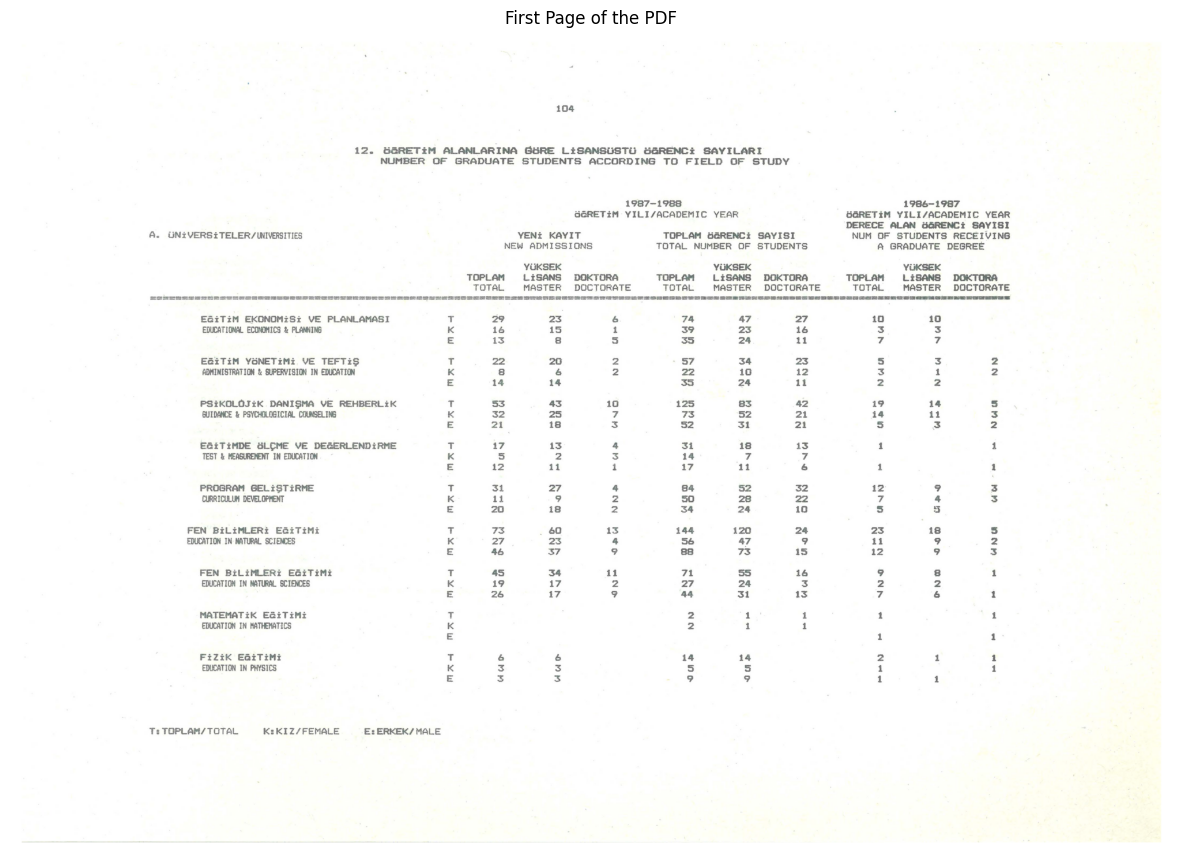

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


PROCESS COMPLETE!
- The Excel file has been automatically downloaded
- Extracted text is in the 'Extracted Text' column

Accuracy: 7.60%


In [32]:
# @title ## 5. Main Workflow

# ----------------------------
# Step 1: Function to remove illegal characters
# ----------------------------
import re

def remove_illegal_characters(text):
    """Clean up unwanted characters from OCR output."""
    # Remove non-ASCII characters and excessive spaces
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ----------------------------
# Step 2: Specify the path to the PDF file
# ----------------------------
pdf_path = '/content/12_1987-1988-36-40.pdf'  # Replace with your actual file name
print(f"Processing PDF: {pdf_path}")

# ----------------------------
# Step 3: Convert the PDF to an image and display it
# ----------------------------
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

# Convert the PDF to an image at high resolution
images = convert_from_path(pdf_path, dpi=300)

# Visualize the first page
plt.figure(figsize=(15, 20))
plt.imshow(images[0])
plt.axis('off')
plt.title("First Page of the PDF")
plt.show()

# ----------------------------
# Step 4: Image processing and OCR
# ----------------------------
import pytesseract
import cv2
import numpy as np

# Convert the image into OpenCV format for processing
image = np.array(images[0])

# Convert to grayscale and apply adaptive thresholding
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
processed_image = cv2.adaptiveThreshold(
    gray_image, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 21, 8
)

# OCR processing (Turkish + English)
config = '--oem 3 --psm 6 -l tur+eng'
raw_text = pytesseract.image_to_string(processed_image, config=config)

# ----------------------------
# Step 5: Clean the text and save it to Excel
# ----------------------------
import pandas as pd
from google.colab import files

# Clean the extracted text
cleaned_text = remove_illegal_characters(raw_text)

# Create a DataFrame
data = {'Extracted Text': [cleaned_text]}
df = pd.DataFrame(data)

# Save to an Excel file
output_file = '/content/Kitap1.xlsx'
df.to_excel(output_file, index=False)

# Provide the option to download the file
files.download(output_file)

print("""
PROCESS COMPLETE!
- The Excel file has been automatically downloaded
- Extracted text is in the 'Extracted Text' column
""")

# ----------------------------
# Step 6: Accuracy Analysis
# ----------------------------
def calculate_accuracy(manual_text, ocr_text):
    """Compare manual text with OCR output."""
    match_count = sum(m == o for m, o in zip(manual_text, ocr_text))
    return (match_count / len(manual_text)) * 100

# Example usage:
manual_text = """104 A. üNiVERSiTELER/UNIVERSITIES EciTiM E~ONOMiSi VE PLANLAMASI ECOtDIICS & PI.AttllN6 Ec'iTiM VöNETiMi VE ADNINISTRATION & SUPERVISION iN EDOCATION PSiKOLOJiK VE REHBERLiK SUIDAICE & CWIS8..IN6 EciTiMDE öLÇME VE DEcERLENDiRHE TEST NEASUlEIENT iN EDOCATJ()j PROGRAM CIJlR ICLll.tt DEVEl.OPIENT FEN BiLiMLERi EciTiMi EDUCATION iN ~TUIAL scmas FEN BiLil'ILERi EciTiMi EDUCATION iN ~MAL SCIOCES MATEMATiK EciTiMi EDOCATICJI iN NATielAHCS FiZiK EciTiMi EDUCATION iN PHYSICS 12. öcRETil1 ALANLAR- INA GöRE LiSANSüSTü öaRENCi SAYILARI NUMBER OF BRADUATE STUDENTS ACCORDINB TO FIELD OF STUDY 1987-1988 öcRETiM YILI/ACADEMIC YEAR YENi KAYIT NEW ADMISSIONS TOPLAM öcRENCi SAYISI TOTAL NUMBER OF STUDENTS TOPLAM TOTAL VüKSEK LiSANS DOKTORA MASTER DOCTORATE YüKSEK LiSANS DOKTORA MASTER OOCTORATE T K E T K E T K E T K E T K E T K E T K E T K E T K E TOPLAN TOTAL 29 16 13 22 8 14 53 32 21 17 5 12 31 11 20 73 27 46 45 19 26 6 3 3 23 15 8 20 6 14 43 25 18 13 2 11 27 9 18 60 23 37 34 17 17 6 3 3 6 1 5 2 2 10 7 3 4 3 1 4 2 2 13 4 9 11 2 9 74 39 35 57 22 35 125 73 52 31 14 17 84 50 34 144 56 88 71 27 44 2 2 14 s 9 47 27 23 16 24 11 34 23 10 12 24 11 83 42 52 21 31 21 18 13 7 7 11 6 52 32 28 22 24 10 120 24 47 9 73 55 16 24 3 31 13 1 1 1 1 14 5 9 T:TOPLAM/TOTAL K:KIZ/FEMALE EzERKEK/MALE 1986-1987 öaRETiM YILI/ACADEMIC YEAR DERECE ALAN ö6RENCt SAYISI NUM OF STUDENTS RECEIVINB A GRADUATE DEGREE TOPLAM TOTAL VüKSEK LiSANS DOKTORA MASTER DOCTORATE 10 3 7 !5 3 2 19 14 5 12 7 !5 23 11 12 9 2 7 2 1 1 10 3 7 3 1 2 14 11 ._ 3 9 4 5 18 9 9 8 2 6 2 2 !5 3 2 3 s 2 3"""  # Replace with the manually copied text from the PDF
accuracy = calculate_accuracy(manual_text, cleaned_text)
print(f"Accuracy: {accuracy:.2f}%")

# Explanation of the Workflow:
	1.	Removing Illegal Characters (Function remove_illegal_characters):
	•	The function is defined to clean the extracted text by removing non-ASCII characters and extra spaces. It also trims any leading or trailing spaces from the text. This is important to clean the raw text extracted from the PDF.
	2.	PDF to Image Conversion:
	•	The pdf2image library is used to convert the first page of the PDF file into an image. This is crucial because Optical Character Recognition (OCR) tools like Tesseract work on images rather than raw text.
	3.	Image Preprocessing:
	•	The image is first converted to grayscale using OpenCV’s cv2.cvtColor(), which helps in reducing the complexity of the image and focusing on text extraction.
	•	Then, adaptive thresholding (cv2.adaptiveThreshold) is applied to further enhance text clarity by improving the contrast between the text and the background.
	4.	OCR (Optical Character Recognition):
	•	The processed image is fed into Tesseract OCR for text extraction. Tesseract is configured to recognize both Turkish and English (-l tur+eng) in the image. The --psm 6 setting specifies that the layout is assumed to be a block of text, which works well for simple page layouts.
	5.	Text Cleaning:
	•	The extracted text is then passed through the remove_illegal_characters function to remove unwanted characters, making the text cleaner and more readable.
	6.	Saving OCR Output to Excel:
	•	The cleaned text is stored in a pandas DataFrame. This allows the text to be structured and easily saved to a file format, in this case, an Excel file. The file is saved as Kitap1.xlsx.
	7.	Download Option:
	•	The generated Excel file (Kitap1.xlsx) is made available for download through files.download(). This allows the user to download the processed text from the PDF as an Excel file.
	8.	Final Output:
	•	The script prints the final message indicating the OCR process is complete and that the Excel file is ready for download.

In [ ]:
# @title ## 6. Parameter Optimization Guide
"""
ADJUSTABLE PARAMETERS:

1. dpi (Image Quality):
   - Low-quality PDFs → 600 DPI
   - Standard documents → 400 DPI
   - High-resolution scans → 300 DPI

2. threshold_block (Thresholding):
   - Noisy backgrounds → 31
   - Clean documents → 21
   - Fine text fonts → 15

3. denoise_strength (Noise Reduction):
   - High noise → 15-20
   - Low noise → 8-12
   - Clean images → 5

4. Language Settings:
   - Only English → lang='eng'
   - Multi-language → lang='eng+deu+fra'
   - Auto-detect languages → lang='osd'
"""
